# Fig 1 + Ext Data Fig 1

This notebook produces all analyses in Figure 1 and Extended Data Figure 1.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from helper_funcs import *

# Import data

In [2]:
redownload = False
gene_effect = read_in_data("CRISPRGeneEffect", redownload=redownload, index_col=0)
cn = read_in_data("OmicsCNGene", redownload=redownload, index_col=0)
expr = read_in_data("OmicsExpressionProteinCodingGenesTPMLogp1", redownload=redownload, index_col=0)
cn_seg = read_in_data("OmicsCNSegmentsProfile", redownload=redownload, index_col=0)
mod_prof = read_in_data("OmicsDefaultModelProfiles", redownload=redownload)
hs_mut = read_in_data("OmicsSomaticMutationsMatrixHotspot", redownload=redownload, index_col=0)
dam_mut = read_in_data("OmicsSomaticMutationsMatrixDamaging", redownload=redownload, index_col=0)
sigs = read_in_data("OmicsSignatures", redownload=redownload, index_col=0)
model_meta = read_in_data("Model", redownload=redownload, index_col=0)

Fetching CRISPRGeneEffect from https://ndownloader.figshare.com/files/43346616
Fetching OmicsCNGene from https://ndownloader.figshare.com/files/43346913
Fetching OmicsExpressionProteinCodingGenesTPMLogp1 from https://ndownloader.figshare.com/files/43347204
Fetching OmicsCNSegmentsProfile from https://ndownloader.figshare.com/files/43346952
Fetching OmicsDefaultModelProfiles from https://ndownloader.figshare.com/files/43346961
Fetching OmicsSomaticMutationsMatrixHotspot from https://ndownloader.figshare.com/files/43347528
Fetching OmicsSomaticMutationsMatrixDamaging from https://ndownloader.figshare.com/files/43347516
Fetching OmicsSignatures from https://ndownloader.figshare.com/files/46500361
Fetching Model from https://ndownloader.figshare.com/files/43746708


# Prep Figure 1 Panels

## Panel A: 9p21.3 Diagram

In [3]:
chr9p21_3 = np.asarray(Image.open('Ch9p21-diagram.png'))

## Panel B/C: 9p21.3 Deletion Call

Cytoband copy number is computed with same method (including [managing gaps](https://github.com/broadinstitute/depmap_omics/blob/cf950f8c695cbf61db39d16718f999c622e1f16d/mgenepy/mutations.py#L8)) used to find gene-level CN in DepMap's Omics pipeline .

In [4]:
def manageGapsInSegments(
    segtocp, Chromosome="Chromosome", End="End", Start="Start", cyto=None
):
    """
    extends the ends of segments in a segment file from GATK so as to remove all gaps ove the genome (works with multiple sample file)

    Args:
    ----
      segtocp: dataframe of segments from GATK CN pipeline
      Chromosome: str the value for the Chromosome columns
      End: str the value for the End columns
      Start: str the value for the Start columns
      cyto: dataframe with chrom;end; columns giving the size of each chromosome (else puts last segment to 1000000000)
    """
    prevchr = ""
    prevend = 0
    count = 0
    l = []
    segments = segtocp.copy()
    le = len(segments)
    for k, val in segments.iterrows():
        # h.showcount(count, le)
        count += 1
        if val[Chromosome] != prevchr:  # we changed chromosome
            # we extend the previous segment (last of the prev chrom) to.. way enough
            if len(l) > 0:
                l[-1][2] = (
                    1000000000
                    if cyto is None
                    else cyto[cyto["chrom"] == prevchr]["end"].values[-1]
                )
            # we extend the first segment to 0
            l.append([val[Chromosome], 0, val[End]])
        else:
            if val[Start] > prevend + 1:  # we have a gap in the same chrom
                sizeofgap = val[Start] - prevend
                # we add to the previous one half of the gap
                l[-1][2] += (
                    int(sizeofgap / 2) if sizeofgap % 2 == 0 else int(sizeofgap / 2) + 1
                )
                # the rest to the other
                l.append([val[Chromosome], val[Start] - int(sizeofgap / 2), val[End]])
            elif val[Start] < prevend:  # this should never happen
                # import pdb; pdb.set_trace()
                raise ValueError("start comes after end")
            else:
                l.append([val[Chromosome], val[Start], val[End]])
        prevchr = val[Chromosome]
        prevend = val[End]
    # we extend the last one
    l[-1][2] = (
        1000000000 if cyto is None else cyto[cyto["chrom"] == prevchr]["end"].values[-1]
    )
    segments[[Chromosome, Start, End]] = l
    return segments.reset_index(drop=True)

model_cn_seg = cn_seg.merge(
    mod_prof[["ProfileID", "ModelID"]], on="ProfileID", how="inner"
)
no_gap = manageGapsInSegments(model_cn_seg)

def compute_weighted_cn(chr, start, end, model_cn_seg):
    '''
    Find the weighted CN per model over a chromosomal region.
    '''
    #get segments for the chromosome that overlap with the region
    region_segs = model_cn_seg.loc[
        (model_cn_seg["Chromosome"] == chr) &
        ((model_cn_seg["End"] > start) & (model_cn_seg["Start"] < end))
    ].sort_values(["ModelID", "Start"]).set_index("ModelID")
    #setup series to capture cn
    region_cn = pd.Series(np.nan, index=model_cn_seg["ModelID"].unique())
    #loop through all models
    for model_id in region_cn.index:
        #get the segments in region for that model
        mod_segs = region_segs.loc[[model_id]]
        #set cn to zero and start to start of gene
        region_cn[model_id] = 0
        curr_start = start
        #iter through segments
        for _, curr_seg in mod_segs.iterrows():
            #weight cn by length of segment covering region / length of region as coef
            coef = (min(curr_seg["End"], end) - curr_start) / (end - start)
            region_cn[model_id] += (curr_seg["SegmentMean"] * coef)
            #set new start to end of last segment
            curr_start = curr_seg["End"]
    return np.log2(region_cn+1)

model_cn_seg_9p21_3 = compute_weighted_cn('9', 19900000, 25600000, no_gap)

In [5]:
fig1b_data = model_cn_seg_9p21_3.to_frame("Relative Copy Number 9p21.3")
fig1b_data["Deleted for thresh 0.4"] = fig1b_data["Relative Copy Number 9p21.3"] < 0.4
fig1b_data["Relative Copy Number 9p21.3"].notnull().sum(), fig1b_data["Deleted for thresh 0.4"].value_counts()

(1750,
 False    1659
 True       91
 Name: Deleted for thresh 0.4, dtype: int64)

In [6]:
del_seg_9p21_3 = model_cn_seg_9p21_3 < 0.4
print(del_seg_9p21_3.reindex(gene_effect.index).value_counts())
#run t-test on gene effect per gene for 9p21.3 del vs intact 
fig1c_volc = compare_it(del_seg_9p21_3, gene_effect, plot=False, alternative="less")
fig1c_volc.loc[["PELO (53918)", "HBS1L (10767)", "WDR77 (79084)", "PRMT5 (10419)"]]

False    1037
True       63
dtype: int64


,n,p,q,Effect Size
PELO (53918),1100,8.449700e-12,7.575578e-08,-0.406377
HBS1L (10767),1100,1.188138e-09,7.101499e-06,-0.144250
WDR77 (79084),1100,4.205677e-12,7.541200e-08,-0.376503
PRMT5 (10419),1100,1.926401e-07,5.757050e-04,-0.219910


In [7]:
fig1d_data = pd.concat({
    "9p21.3 Relative Copy Number":model_cn_seg_9p21_3,
    "PELO Dependency":gene_effect["PELO (53918)"],
    "MSI-H":sigs["MSIScore"] > 20,
}, axis=1, join="inner")
fig1d_data['9p21.3 Relative Copy Number'].notnull().sum(), fig1d_data['MSI-H'].sum()

(1100, 73)

## Panel E: 9p21.3 Intact vs Omics Features 

In [8]:
all_feats = pd.concat([
    expr.add_prefix("EXPR_"),
    cn.add_prefix("CN_"),
    hs_mut.add_prefix("HS_"),
    dam_mut.add_prefix("DAM_"),
    sigs,
], axis=1)
all_feats = all_feats.loc[:, (all_feats.notnull().sum() > 10)]

In [9]:
pelo_dep = gene_effect.loc[gene_effect.index.isin(del_seg_9p21_3.index[~del_seg_9p21_3]), "PELO (53918)"]
pelo_dep.shape[0]

1037

In [10]:
#pearson correlation between PELO gene effect in 9p21.3 intact and all Omics features
fig1e_volc = compare_it_continuous(
    pelo_dep, all_feats,
    plot=False, alternative="two-sided"
)
fig1e_volc.loc[["MSIScore", "EXPR_TTC37 (9652)"]]

,n,p,q,Effect Size
MSIScore,1037.0,1.583335e-25,9.517267e-21,-0.316301
EXPR_TTC37 (9652),960.0,7.805017e-11,1.091051e-07,0.207899


## Panel F: Dependency Fan Plot

In [11]:
fig1f_data = pd.concat({
    "PELO Dependency":gene_effect["PELO (53918)"],
    "Oncotree Lineage":model_meta["OncotreeLineage"]
}, axis=1).dropna(subset=["PELO Dependency"])
small_lineages = pd.Series("Other", fig1f_data.groupby("Oncotree Lineage").size().loc[lambda x: x < 20].index)
fig1f_data["Oncotree Lineage Slim"] = fig1f_data["Oncotree Lineage"].replace(small_lineages).replace(SHORT_ONCO_NAMES)

categories = sorted(fig1f_data["Oncotree Lineage Slim"].dropna().unique())
colormap = sns.color_palette(COLORS, len(categories))
colors = pd.Series(dict(zip(categories, colormap))).apply(list)

fig1f_data.shape[0]

1100

# Construct Figure 1

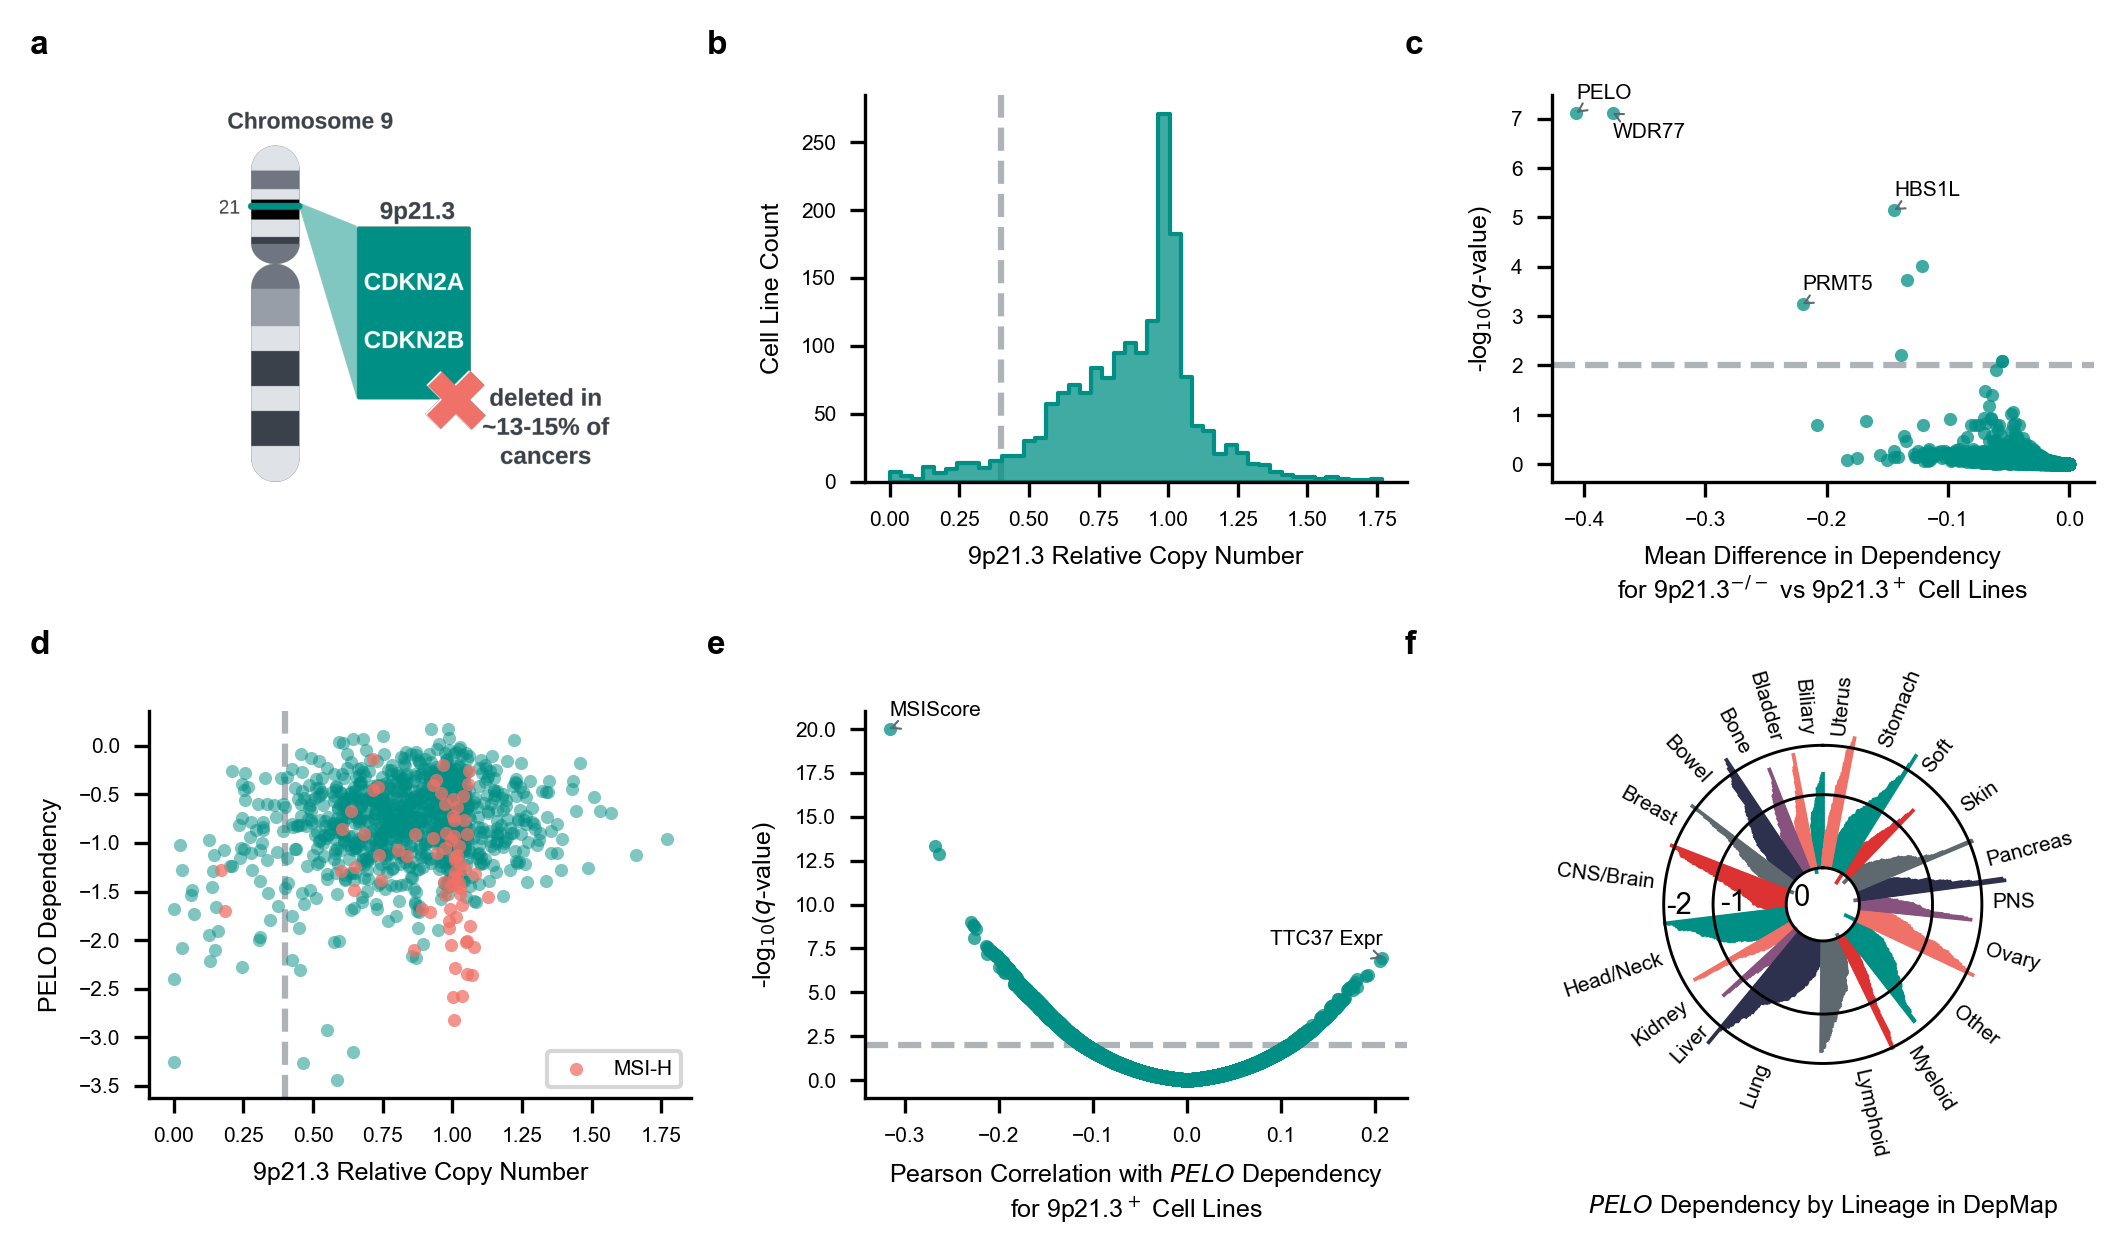

In [12]:
fig1 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN, 4))

gs = fig1.add_gridspec(nrows=2, ncols=3)

A = fig1.add_subplot(gs[0, 0])
A.imshow(chr9p21_3, aspect='equal')
A.set_axis_off()

B = fig1.add_subplot(gs[0, 1])
sns.histplot(fig1b_data["Relative Copy Number 9p21.3"], binwidth=0.04, ax=B, element='step')
axline(B, "v", 0.4)
B.set_xlabel("9p21.3 Relative Copy Number")
B.set_ylabel("Cell Line Count")


C = fig1.add_subplot(gs[0, 2])
quick_scatter(
    x=fig1c_volc.loc[fig1c_volc["Effect Size"] < 0, "Effect Size"].rename(
        "Mean Difference in Dependency\nfor "r"9p21.3$^{-/-}$ vs 9p21.3$^+$"" Cell Lines"
    ),
    y=-np.log10(fig1c_volc["q"]).rename("-log$_{10}$($q$-value)"), 
    hline=-np.log10(0.01), linewidth=0, alpha=0.75, ax=C, s=10
)
for text, idx, y_adj in [
    ("PELO", "PELO (53918)", 0.2),
    ("WDR77", "WDR77 (79084)", -0.2),
    ("PRMT5", "PRMT5 (10419)", 0.2),
    ("HBS1L", "HBS1L (10767)", 0.2),
]:
    C.annotate(
        text, xy=(fig1c_volc.loc[idx, "Effect Size"], -np.log10(fig1c_volc.loc[idx, "q"])),
        xytext=(fig1c_volc.loc[idx, "Effect Size"], -np.log10(fig1c_volc.loc[idx, "q"])+y_adj),
        arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
        horizontalalignment='left', verticalalignment='bottom' if y_adj > 0 else 'top'
    )

D = fig1.add_subplot(gs[1, 0])

sns.scatterplot(
    data=fig1d_data.loc[~fig1d_data["MSI-H"]], x="9p21.3 Relative Copy Number", y="PELO Dependency",
    s=10, linewidth=0, alpha=0.5, ax=D
)
sns.scatterplot(
    data=fig1d_data.loc[fig1d_data["MSI-H"]], x="9p21.3 Relative Copy Number", y="PELO Dependency",
    s=10, linewidth=0, alpha=0.75, label="MSI-H", ax=D
)
axline(D, "v", 0.4)
D.legend(loc="lower right")

E = fig1.add_subplot(gs[1, 1])
quick_scatter(
    x=fig1e_volc["Effect Size"].rename(r"Pearson Correlation with $PELO$"" Dependency\nfor "r"9p21.3$^+$"" Cell Lines"),
    y=-np.log10(fig1e_volc["q"]).rename("-log$_{10}$($q$-value)"),
    hline=-np.log10(0.01), s=10, linewidth=0, alpha=0.75, ax=E
)
for text, idx, y_adj, ha in [
    ("MSIScore", "MSIScore", 0.5, "left"),
    ("TTC37 Expr", "EXPR_TTC37 (9652)", 0.5, "right"),
]:
    E.annotate(
        text, xy=(fig1e_volc.loc[idx, "Effect Size"], -np.log10(fig1e_volc.loc[idx, "q"])),
        xytext=(fig1e_volc.loc[idx, "Effect Size"], -np.log10(fig1e_volc.loc[idx, "q"])+y_adj),
        arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
        horizontalalignment=ha, verticalalignment='bottom' if y_adj > 0 else 'top'
    )

F = fig1.add_subplot(gs[1, 2], polar=True)
fan_plot(
    fig1f_data, "PELO Dependency", groups="Oncotree Lineage Slim", hue="Oncotree Lineage Slim", inverse=True, 
    gap=0.5, h_lines={"0":0, "-1":1, "-2":2}, h_line_angle=-4.65, 
    fontsize=5,  labelpad=23, label_dist=6,
    title=r"$PELO$ Dependency by Lineage in DepMap", colors=colors, ax=F,  
)


fig1.text(0.01, 1, "a", weight='bold', fontsize=8)
fig1.text(0.33, 1, "b", weight='bold', fontsize=8)
fig1.text(0.66, 1, "c", weight='bold', fontsize=8)
fig1.text(0.01, 0.5, "d", weight='bold', fontsize=8)
fig1.text(0.33, 0.5, "e", weight='bold', fontsize=8)
fig1.text(0.66, 0.5, "f", weight='bold', fontsize=8)

fig1.set_constrained_layout_pads(
    w_pad = 0.1, h_pad = 0.1
)

plt.savefig("figures/Fig1.pdf", transparent=True, bbox_inches='tight',)
plt.savefig("figures/Fig1.png", transparent=True, bbox_inches='tight',)

## Extended Data Figure Panel A: Various Thresholds

In [13]:
thresholds = [0.2, 0.3, 0.5, 0.6]
thresh_dicts = {}
for t, thresh in enumerate(thresholds):
    curr_thresh_dict = {}
    curr_thresh_dict["deleted"] = model_cn_seg_9p21_3 < thresh
    curr_thresh_dict["result"] = compare_it(curr_thresh_dict["deleted"], gene_effect, plot=False)
    #run t-test on gene effect per gene for 9p21.3 del vs intact with various definitions of del
    curr_thresh_dict["outliers"] = (
        ((curr_thresh_dict["result"]["q"] < 0.01) & (curr_thresh_dict["result"]["Effect Size"] < -0.17))
    ).loc[lambda x: x].index
    thresh_dicts[thresh] = curr_thresh_dict

## Extended Data Figure Panel B: MSI-H vs Gene Effect

In [14]:
#run t-test on gene effect per gene for MSI-H vs MSS
extfig1b_volc = compare_it(
    sigs["MSIScore"] > 20, gene_effect.loc[model_cn_seg_9p21_3 > 0.4], 
    plot=False, alternative="two-sided"
)
extfig1b_volc.loc[["PELO (53918)", "WRN (7486)"]]

,n,p,q,Effect Size
PELO (53918),1037,3.240017e-20,1.452419e-16,-0.500084
WRN (7486),1037,1.126677e-76,2.020244e-72,-0.690588


In [15]:
(sigs.reindex(gene_effect.loc[model_cn_seg_9p21_3 > 0.4].index)["MSIScore"] > 20).value_counts()

False    966
True      71
Name: MSIScore, dtype: int64

# Construct Extended Data Figure 1

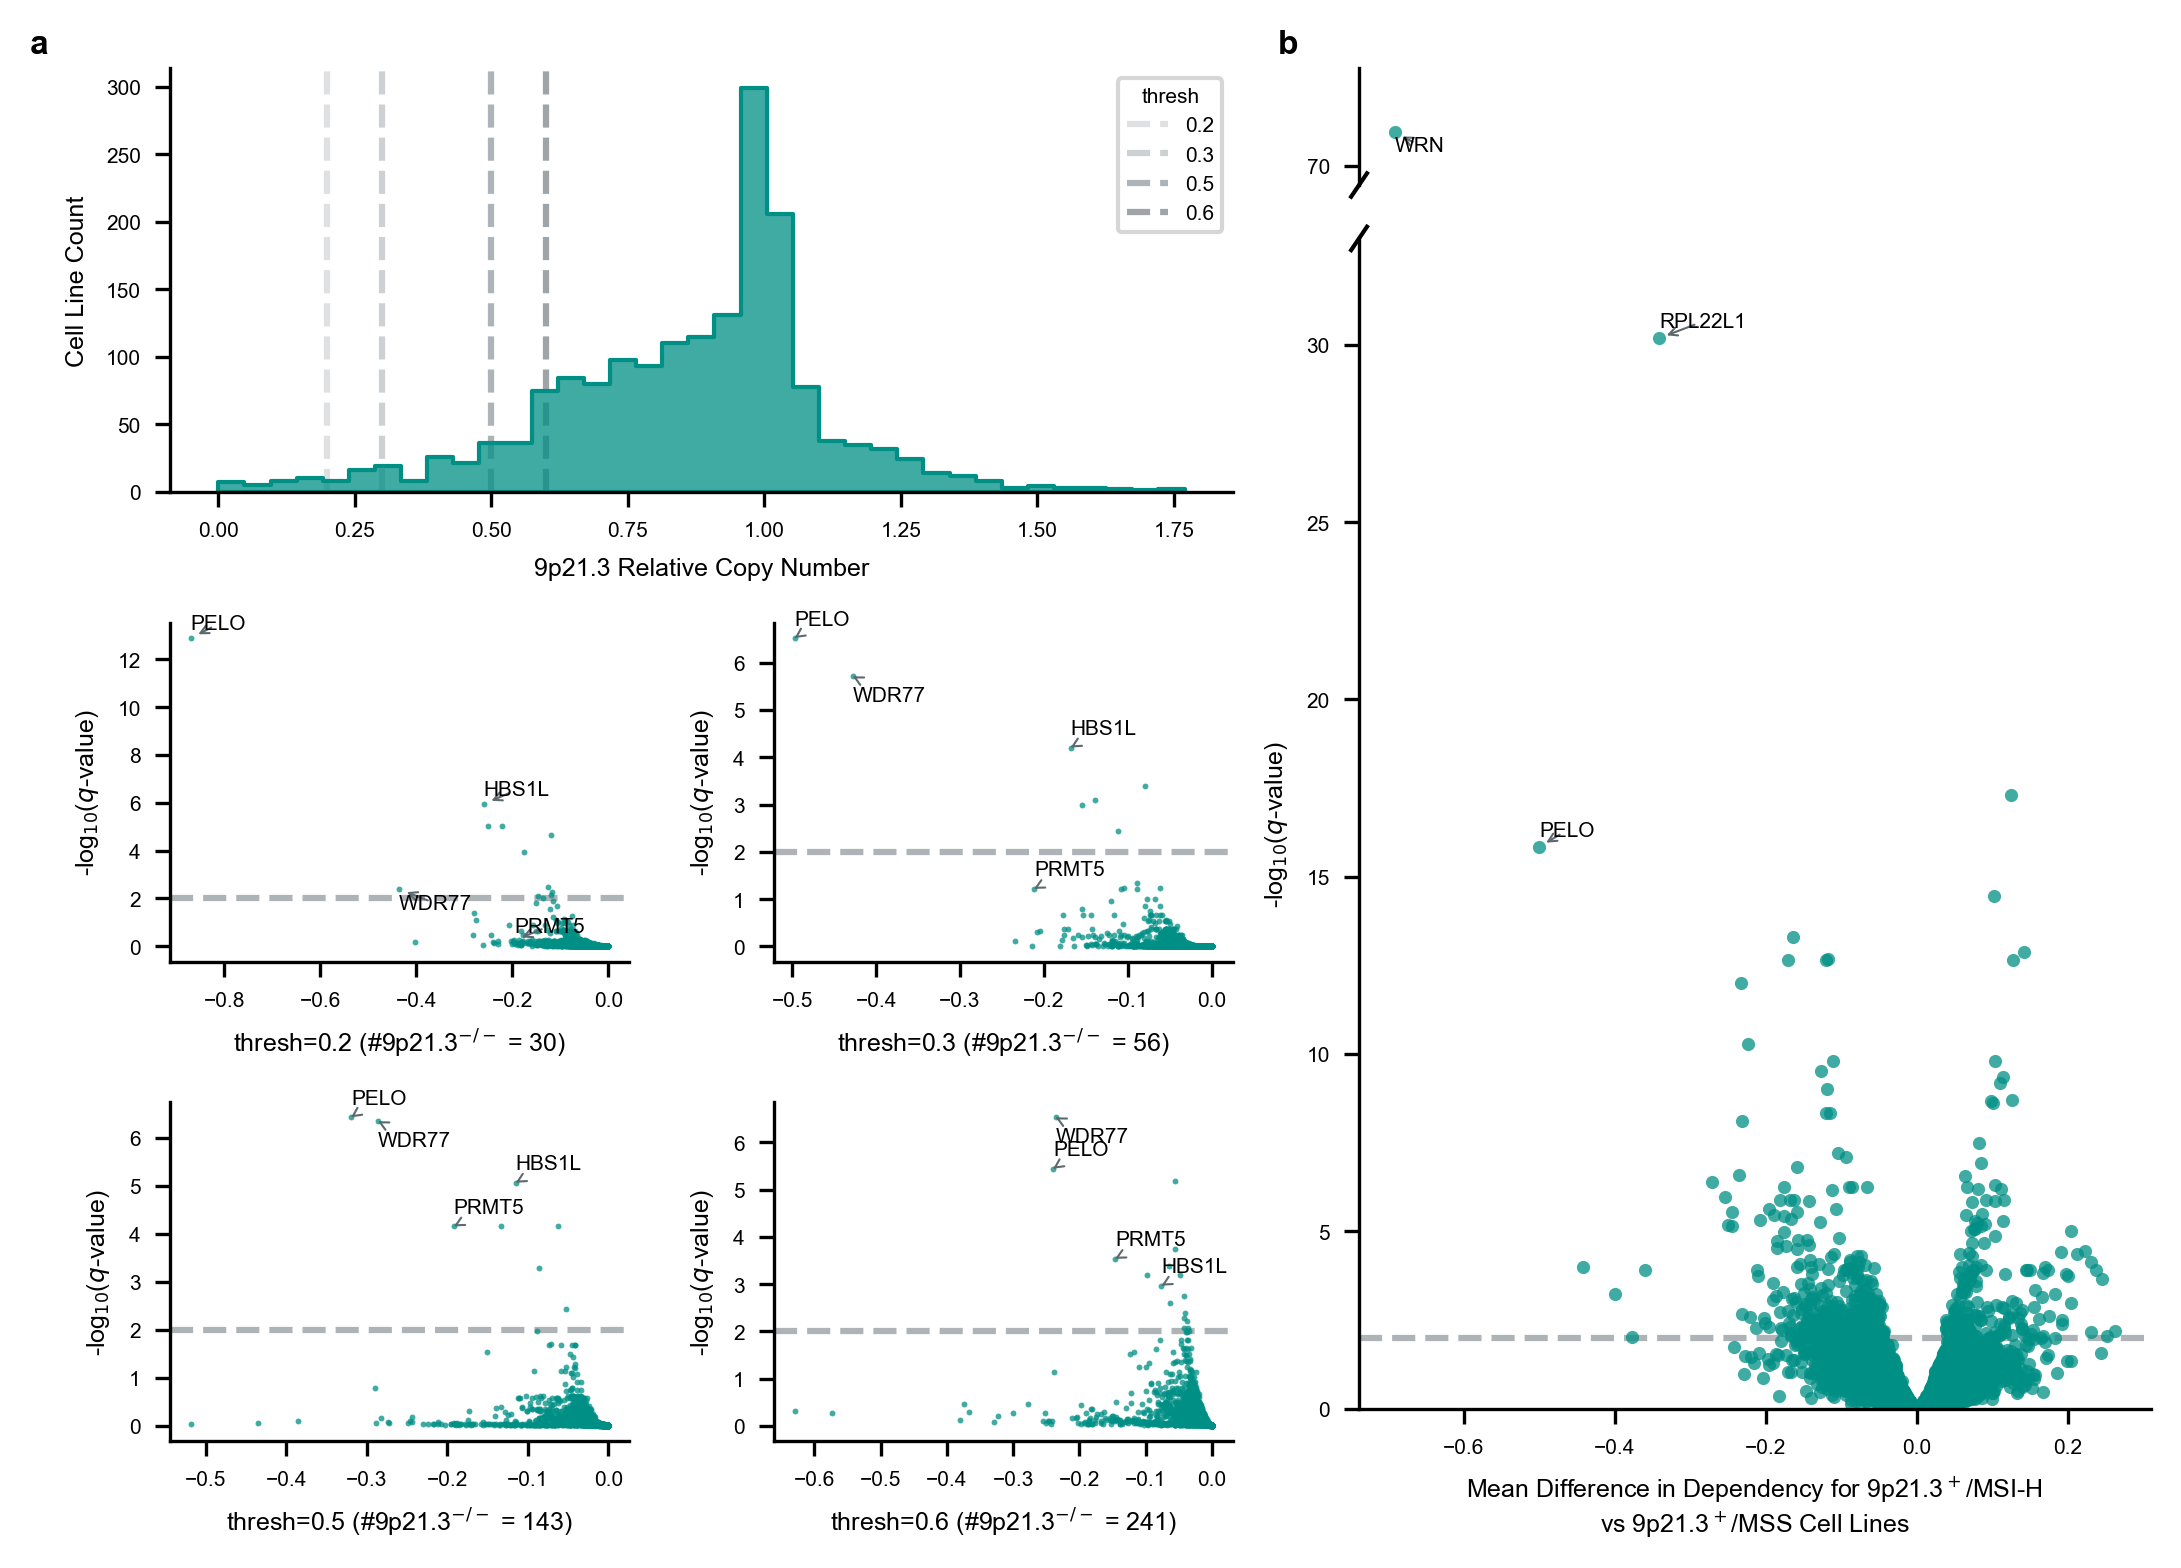

In [16]:
extfig1 = plt.figure(layout="constrained", dpi=300, figsize=(DOUBLE_IN, 5))

gs = extfig1.add_gridspec(nrows=3, ncols=3, width_ratios=[1,1,2], height_ratios=[1.25,1,1])

A = extfig1.add_subplot(gs[0, 0:2])
sns.histplot(model_cn_seg_9p21_3, ax=A, element='step')
A.set_xlabel("9p21.3 Relative Copy Number")
A.set_ylabel("Cell Line Count")
for thresh in thresh_dicts.keys():
    axline(A, "v", thresh, alpha=thresh, label=thresh)
A.legend(title="thresh")

for t, thresh in enumerate(thresh_dicts.keys()):
    i, j = 1+(t // 2),  (t % 2)
    curr_thresh_dict = thresh_dicts[thresh]
    A2 = extfig1.add_subplot(gs[i, j])
    quick_scatter(
        x=curr_thresh_dict["result"].loc[
            curr_thresh_dict["result"]["Effect Size"]< 0, "Effect Size"
        ],
        y=-np.log10(curr_thresh_dict["result"]["q"]).rename("-log$_{10}$($q$-value)"),
        hline=-np.log10(0.01), figsize=(3,3), linewidth=0, alpha=0.75, s=2, ax=A2
    )
    n = curr_thresh_dict["deleted"].sum()
    A2.set_xlabel(f"thresh={thresh} "r"(#9p21.3$^{-/-}$"f" = {n})")
    for text, idx, y_adj in [
        ("PELO", "PELO (53918)", 0.2),
        ("WDR77", "WDR77 (79084)", -0.2),
        ("PRMT5", "PRMT5 (10419)", 0.2),
        ("HBS1L", "HBS1L (10767)", 0.2),
    ]:
        A2.annotate(
            text, xy=(curr_thresh_dict["result"].loc[idx, "Effect Size"], -np.log10(curr_thresh_dict["result"].loc[idx, "q"])),
            xytext=(curr_thresh_dict["result"].loc[idx, "Effect Size"], -np.log10(curr_thresh_dict["result"].loc[idx, "q"])+y_adj),
            arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
            horizontalalignment='left', verticalalignment='bottom' if y_adj > 0 else 'top'
        )

gs02 = gs[:3, 2].subgridspec(nrows=2, ncols=1, height_ratios=[0.1, 1], hspace=0)
B = extfig1.add_subplot(gs02[0])
outliers = ((extfig1b_volc["Effect Size"].abs() > 0.3) & ((extfig1b_volc["q"] < 1e6))).loc[lambda x: x].index
outliers = pd.Series(outliers.str.split(" ").str[0], outliers.to_list())
sns.scatterplot(
    x=extfig1b_volc["Effect Size"],
    y=-np.log10(extfig1b_volc["q"]),
    s=10, linewidth=0, alpha=0.75, ax=B
)
B.set_ylim(69,75)
B.set_xlabel(None)
B.set_ylabel(None)
B.spines["bottom"].set_visible(False)
B.axes.get_xaxis().set_visible(False)
B.set_yticks([70])
B2 = extfig1.add_subplot(gs02[1])
sns.scatterplot(
    x=extfig1b_volc["Effect Size"].rename(r"Mean Difference in Dependency for 9p21.3$^+$/MSI-H "'\n'r"vs 9p21.3$^+$/MSS Cell Lines"),
    y=-np.log10(extfig1b_volc["q"]).rename("-log$_{10}$($q$-value)"),
    s=10, linewidth=0, alpha=0.75, ax=B2
)
axline(B2, "h", -np.log10(0.01))
B2.set_ylim(0,33)
kwargs = dict(transform=B.transAxes, color='k', linewidth=1, clip_on=False)
d = .01
B.plot((-d, +d), (-d / 0.1, +d / 0.1), **kwargs) 
kwargs.update(transform=B2.transAxes)
B2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
B.annotate(
    "WRN", xy=(extfig1b_volc.loc["WRN (7486)", "Effect Size"], -np.log10(extfig1b_volc.loc["WRN (7486)", "q"])),
    xytext=(extfig1b_volc.loc["WRN (7486)", "Effect Size"], -np.log10(extfig1b_volc.loc["WRN (7486)", "q"])-0.2),
    arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
    horizontalalignment='left', verticalalignment='top'
)
for text, idx, y_adj in [
    ("PELO", "PELO (53918)", 0.2),
    ("RPL22L1", "RPL22L1 (200916)", 0.2)
]:
    B2.annotate(
        text, xy=(extfig1b_volc.loc[idx, "Effect Size"], -np.log10(extfig1b_volc.loc[idx, "q"])),
        xytext=(extfig1b_volc.loc[idx, "Effect Size"], -np.log10(extfig1b_volc.loc[idx, "q"])+y_adj),
        arrowprops=dict(arrowstyle='->', linewidth=0.5, color=ACCENT),
        horizontalalignment='left', verticalalignment='bottom' if y_adj > 0 else 'top'
    )


extfig1.text(-0.01, 1, "a", weight='bold', fontsize=8)
extfig1.text(0.58, 1, "b", weight='bold', fontsize=8)

extfig1.set_constrained_layout_pads(
    w_pad = 0.05, h_pad = 0.05
)

plt.savefig("figures/ExtFig1.pdf", transparent=True, bbox_inches='tight',)
plt.savefig("figures/ExtFig1.png", transparent=True, bbox_inches='tight',)

# Save outputs

In [18]:
fig1b_data.rename_axis("ModelID").to_csv("outputs/Fig1b.csv")
fig1c_volc.rename_axis("Gene").to_csv("outputs/Fig1c.csv")
fig1d_data.rename_axis("ModelID").to_csv("outputs/Fig1d.csv")
fig1e_volc.rename_axis("Gene").to_csv("outputs/Fig1e.csv")
fig1f_data.rename_axis("ModelID").to_csv("outputs/Fig1f.csv")

In [19]:
extfig1a_data = pd.concat({k:v["result"] for k, v in thresh_dicts.items()}).reset_index().rename(
    columns={"level_0":"Threshold", "level_1":"Gene"}
)
extfig1a_data.to_csv("outputs/ExtFig1a.csv", index=None)
extfig1b_volc.rename_axis("Gene").to_csv("outputs/ExtFig1b.csv")